In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics_flat
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random
from scipy.optimize import minimize

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [3]:
file = uproot.open("/eos/experiment/fcc/ee/tmp/flatntuples/Z_Zbb_Bc2TauNu/events_Bc2TauNu.root")
tree = file['events']

In [4]:
events = tree.arrays(library="ak", how="zip")
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
MC_px                | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
MC_py                | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
MC_pz                | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
MC_p                 | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
MC_e                 | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
MC_pdg               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
MC_charge            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
MC_mass              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
MC_status            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
MC_vertex_x          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
MC_vertex_y          | std::

In [5]:
#Reco particles
rp = events["RP"]

#Index cut to remove negative indices (particles produced before hadronisation)
parentindex_cut = rp["MC_parentindex"] >= 0
rp = rp[parentindex_cut]
grandparentindex_cut = rp["MC_grandparentindex"] >= 0
rp = rp[grandparentindex_cut]

#Match to MC
rp["parent_pdg"] = events["MC","pdg"][rp["MC_parentindex"]]
rp["grandparent_pdg"] = events["MC","pdg"][rp["MC_grandparentindex"]]

#Get the production vertex of the track
for v in ["x","y","z"]:
    rp[f"vertex_{v}"] = events["MC",f"vertex_{v}"][rp["MC_index"]] 
#Separation of vertex from PV (combined tau and Bc flight)
rp["PVsep"] = np.sqrt(rp[f"vertex_x"]**2 + rp[f"vertex_y"]**2 + rp[f"vertex_z"]**2)

In [6]:
#Pions
pi_cut = abs(rp["mass"] - lp.pi_plus.mass/1000.) < 1e-4
pions = rp[pi_cut]
p_cut = pions["p"] > 0.
pions = pions[p_cut]

In [7]:
#Build the tau -> 3pi
tau = ak.combinations(pions,3)
tau["pi_1"], tau["pi_2"], tau["pi_3"] = ak.unzip(tau)

#Charge cut on the pions
tau_charge_cut_1 = np.sign(tau["pi_1","charge"]) != np.sign(tau["pi_3","charge"]) 
tau_charge_cut_2 = np.sign(tau["pi_2","charge"]) != np.sign(tau["pi_3","charge"])
tau_charge_cut = np.logical_and(tau_charge_cut_1, tau_charge_cut_2)

tau = tau[tau_charge_cut]

PDG_pi_m = lp.pi_plus.mass/1000.
tau["mass"] = kinematics_flat.mass([tau["pi_1"], tau["pi_2"], tau["pi_3"]], [PDG_pi_m, PDG_pi_m, PDG_pi_m])
tau_m_low_cut_val = 3*PDG_pi_m
tau_m_high_cut_val = lp.tau_plus.mass/1000.
tau_m_low_cut = tau["mass"] >= tau_m_low_cut_val
tau_m_high_cut = tau["mass"] <= lp.tau_plus.mass/1000.
tau_m_cut = np.logical_and(tau_m_low_cut, tau_m_high_cut)
tau = tau[tau_m_cut]

#Truth-matching

#Pion parents are all tau
tau_parent_cut_pi1 = abs(tau["pi_1"]["parent_pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_pi2 = abs(tau["pi_2"]["parent_pdg"]) == abs(lp.tau_plus.pdgid) 
tau_parent_cut_pi3 = abs(tau["pi_3"]["parent_pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_12 = np.logical_and(tau_parent_cut_pi1, tau_parent_cut_pi2)
tau_parent_cut_all = np.logical_and(tau_parent_cut_12, tau_parent_cut_pi3)
tau = tau[tau_parent_cut_all]

#Pion grandparent are all Bc
tau_grandparent_cut_pi1 = abs(tau["pi_1"]["grandparent_pdg"]) == abs(lp.B_c_plus.pdgid)
tau_grandparent_cut_pi2 = abs(tau["pi_2"]["grandparent_pdg"]) == abs(lp.B_c_plus.pdgid) 
tau_grandparent_cut_pi3 = abs(tau["pi_3"]["grandparent_pdg"]) == abs(lp.B_c_plus.pdgid)
tau_grandparent_cut_12 = np.logical_and(tau_grandparent_cut_pi1, tau_grandparent_cut_pi2)
tau_grandparent_cut_all = np.logical_and(tau_grandparent_cut_12, tau_grandparent_cut_pi3)
tau = tau[tau_grandparent_cut_all]

#Ensure pions come from the same tau
tau_parent_cut_12 = tau["pi_1","MC_parentindex"] == tau["pi_2","MC_parentindex"]
tau_parent_cut_13 = tau["pi_1","MC_parentindex"] == tau["pi_3","MC_parentindex"]
tau_parent_cut = np.logical_and(tau_parent_cut_12, tau_parent_cut_13)
tau = tau[tau_parent_cut]

#Net charge of the tau
tau["charge"] = tau["pi_1","charge"] + tau["pi_2","charge"] + tau["pi_3","charge"]

#Tau energy (visible energy of the signal)
for comp in ["x","y","z"]:
    tau[f"p{comp}"] = tau["pi_1",f"p{comp}"] + tau["pi_2",f"p{comp}"] + tau["pi_1",f"p{comp}"]
tau["p"] = np.sqrt(tau["px"]**2 + tau["py"]**2 + tau["pz"]**2)
tau["e"] = np.sqrt(tau["mass"]**2 + tau["p"]**2)

In [8]:
#Total energy of the event and of each hemisphere, use to calculate energy asymmetry and also nominal B energy
rp_all = events["RP"]
rp_all["e"] = np.sqrt(rp_all["p"]**2 + rp_all["mass"]**2)

#Filter out particles with negative parent index
#rp_cut = rp_all["MC_parentindex"] >= 0
#rp_all = rp_all[rp_cut]

#Split into hemispheres

#Non-signal side (points away from thrust axis i.e. towards side with more energy)
rp_non_sig_cut = rp_all["thrustangle"] < 0
rp_non_sig = rp_all[rp_non_sig_cut]

#Signal side
rp_sig_cut = rp_all["thrustangle"] >= 0
rp_sig = rp_all[rp_sig_cut]

#Total energy on both sides
non_sig_e = ak.sum(rp_non_sig['e'],axis=1)
sig_e = ak.sum(rp_sig['e'],axis=1)

tot_e = ak.sum(rp_all['e'],axis=1)

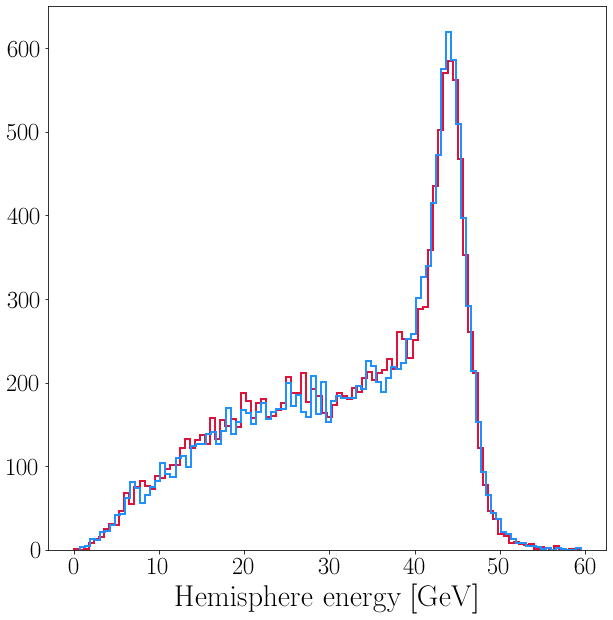

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
plt.hist(sig_e,bins=100,color="crimson",histtype='step',linewidth=2)
plt.hist(non_sig_e,bins=100,color="dodgerblue",histtype='step',linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel("Hemisphere energy [GeV]",fontsize=30)
plt.show()

In [10]:
events["thrust_mag"] = np.sqrt(events["EVT_thrust_x"]**2+events["EVT_thrust_y"]**2+events["EVT_thrust_z"]**2)
for comp in ["x","y","z"]:
    events[f"thrust_{comp}_norm"] = events[f"EVT_thrust_{comp}"] / events["thrust_mag"] 

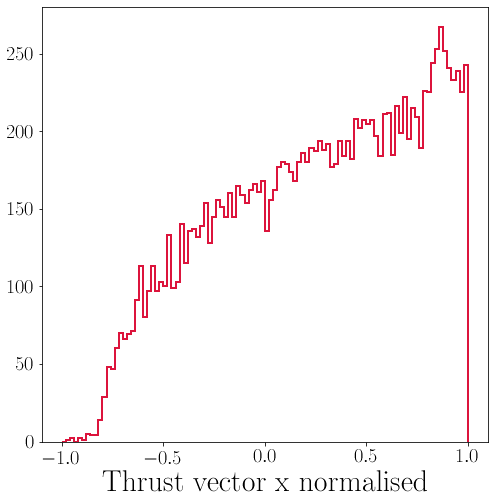

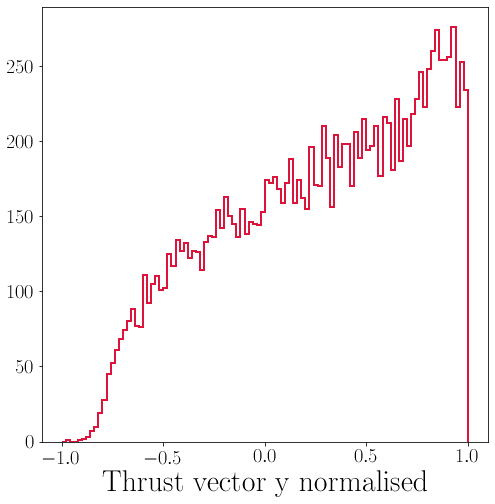

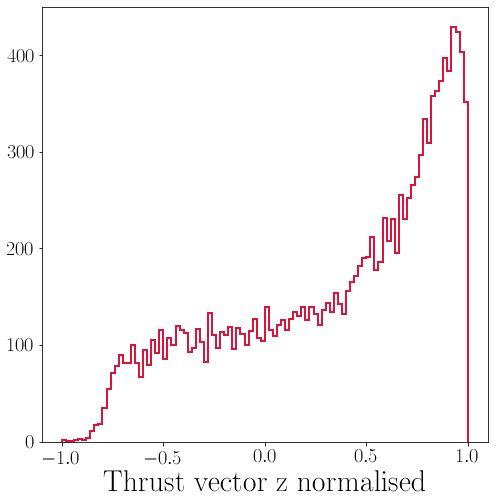

In [12]:
for comp in ["x","y","z"]:
    fig,ax = plt.subplots(figsize=(8,8))
    plt.hist(events[f"EVT_thrust_{comp}"]/events["thrust_mag"],range=(-1,1),bins=100,color='crimson',histtype='step',linewidth=2)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xlabel(f"Thrust vector {comp} normalised",fontsize=30)
    plt.show()

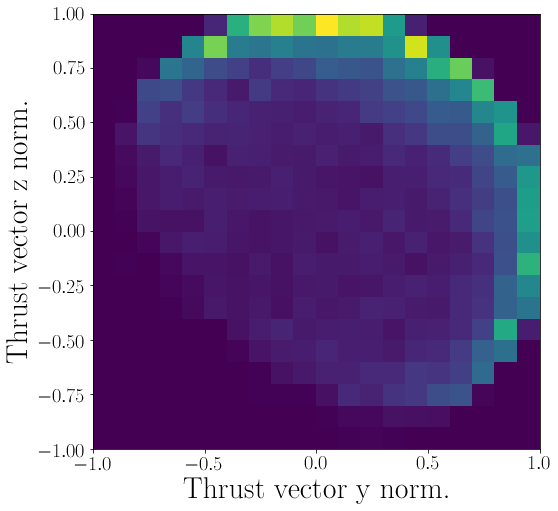

In [13]:
fig,ax = plt.subplots(figsize=(8,8))
plt.hist2d(events["thrust_y_norm"].tolist(), events["thrust_z_norm"].tolist(),range=[[-1,1],[-1,1]],bins=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel("Thrust vector y norm.",fontsize=30)
plt.ylabel("Thrust vector z norm.",fontsize=30)
plt.show()